In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy.external as sce
import decoupler as dc
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from matplotlib.patches import Patch
from insitupy.utils._regression import smooth_fit

In [2]:
adata=ad.read_h5ad("./results_preneopl_acinar_harm.h5ad")

In [3]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["anno_TM"] == "Azini normal")[0]

In [4]:
sc.tl.dpt(adata)

In [5]:
sc.tl.paga(adata, groups="anno_TM")

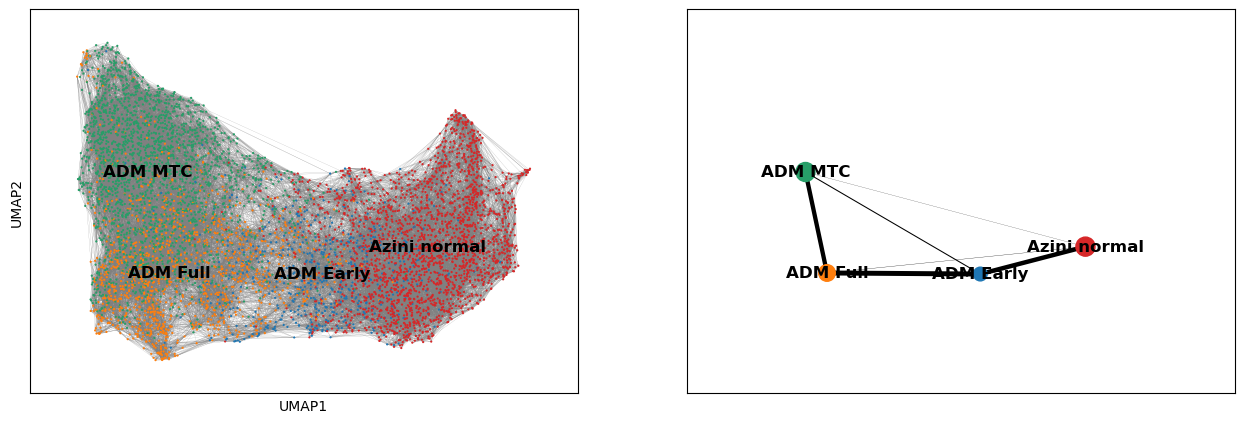

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [6]:
sc.pl.paga_compare(
    adata,
    threshold=0.03,
    title="",
    right_margin=0.2,
    size=10,
    edge_width_scale=0.5,
    legend_fontsize=12,
    fontsize=12,
    frameon=True,
    edges=True,
    save=False,
)

In [7]:
adata.write("./results_preneopl_acinar_harm_paga_pseudotime.h5ad")

In [8]:
adata.obs['dpt_pseudotime'] = adata.obs['dpt_pseudotime'].astype(float)
adata = adata[adata.obs.sort_values('dpt_pseudotime').index]
adata.obs['anno_TM'] = adata.obs['anno_TM'].astype('category')
adata.obs['anno_TM'] = pd.Categorical(adata.obs['anno_TM'], categories=['Azini normal'] + list(adata.obs['anno_TM'].cat.categories.difference(['Azini normal'])))

genes_of_interest = ["Amy1", "Cldn10", "Cldn18", "Ctsl", "Krt19", "Msln", "Tspan8"]

missing_genes = [gene for gene in genes_of_interest if gene not in adata.var_names]
if missing_genes:
    raise ValueError(f"These genes are not in the dataset: {', '.join(missing_genes)}")

C:\Users\thmet\AppData\Local\Temp\ipykernel_19080\704451982.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['anno_TM'] = adata.obs['anno_TM'].astype('category')


In [9]:
adata_df = adata.to_df()
data = adata_df.loc[:, genes_of_interest]

In [10]:
min_max_scaler = MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns, index=data.index)

In [11]:
obs = adata.obs.copy()
obs_cc = obs.sort_values("dpt_pseudotime")
categories = obs_cc[["anno_TM"]]
data = data.loc[categories.index].T
cmap = plt.get_cmap("tab10")
color_map = {elem: cmap(i) for i, elem in enumerate(['ADM Early', 'ADM Full', 'ADM MTC', 'Azini normal'])}
cat_colors = pd.DataFrame({"anno_TM": [color_map[elem] for elem in categories["anno_TM"]]})
categories["anno_TM"].unique()
cat_colors.index = categories.index

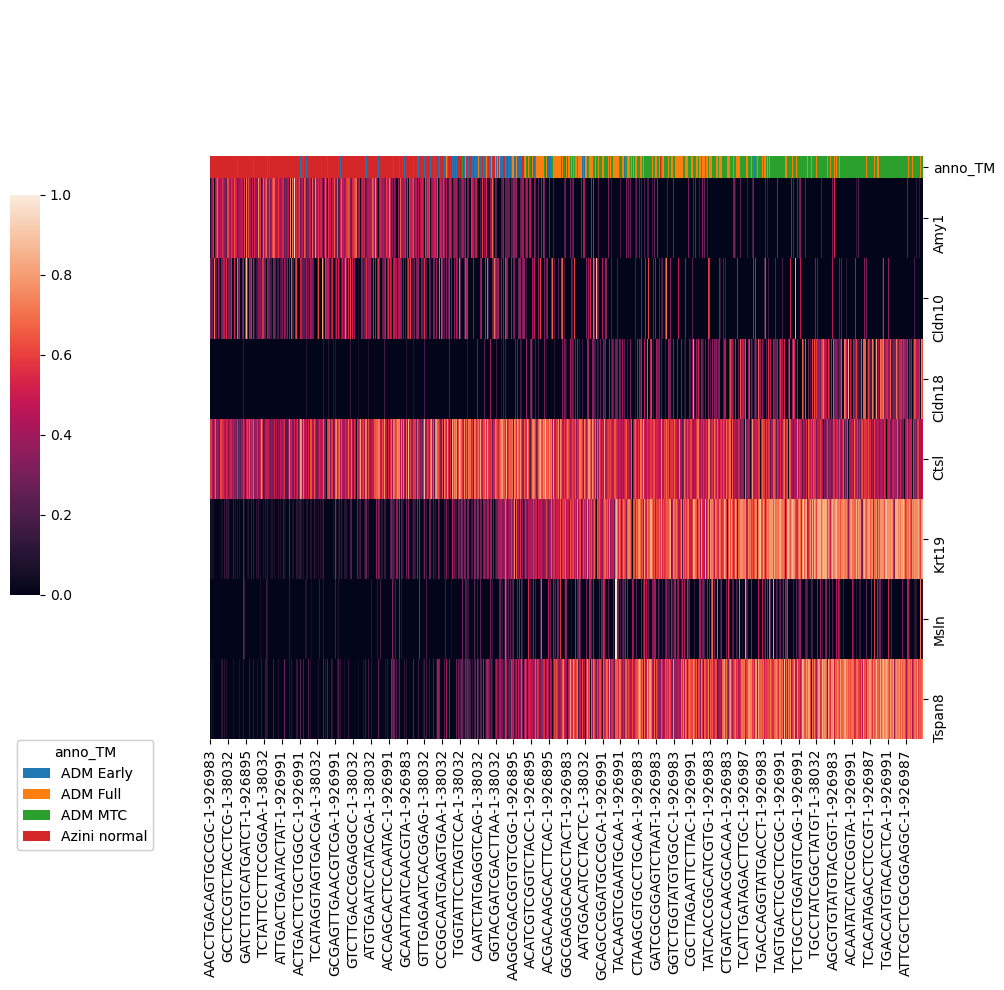

In [12]:
g = sns.clustermap(data, row_cluster=False, col_cluster=False, col_colors=cat_colors)

g.ax_cbar.set_position((0, 0.4, .03, .4))

handles = [Patch(facecolor=color_map[name]) for name in color_map]
first_legend = plt.legend(handles, color_map, title='anno_TM',
           bbox_to_anchor=(0, 0.2),
           bbox_transform=plt.gcf().transFigure,
           loc='center left')

ax = plt.gca().add_artist(first_legend)

In [13]:
data = data.T
data = data.reset_index()
pseudotime = obs_cc[["dpt_pseudotime"]].copy()
pseudotime = pd.concat([pseudotime]*10, ignore_index=True)
data_melted = pd.melt(data, id_vars=["index"], var_name="gene", value_name="expression")
max_value=6537
data_melted["number"] = [(i % max_value) + 1 for i in range(len(data_melted))]
data_melted["dpt_pseudotime"] = pseudotime["dpt_pseudotime"]

In [14]:
data2=data.copy()
obs_cc2 = obs_cc.reset_index()
data2["dpt_pseudotime"] = obs_cc2["dpt_pseudotime"]

In [15]:
data2 = data2.drop("index", axis=1)
all_genes_melted = pd.melt(data2, id_vars=["dpt_pseudotime"], var_name="gene", value_name="expression")

In [16]:
df_list = []
for gene in genes_of_interest:
    smooth = smooth_fit(ys=data2[gene], xs=data2['dpt_pseudotime'], method="loess", stderr=True, nsteps=1000)
    df_smooth = pd.DataFrame(smooth, columns=['x', "y_pred", "conf_lower", "conf_upper"])
    df_smooth.rename(columns={"y_pred": f"{gene}_rel", "conf_lower": f"{gene}_conf_lower", "conf_upper": f"{gene}_conf_upper"}, inplace=True)
    df_list.append(df_smooth.set_index('x'))
df_all_genes = pd.concat(df_list, axis=1)
df_all_genes = df_all_genes.reset_index()
all_genes_melted = pd.melt(df_all_genes, id_vars=["x"], var_name='variable', value_name='value')
all_genes_melted[['gene', 'measure']] = all_genes_melted['variable'].str.split('_', n=1, expand=True)
df_final = all_genes_melted.pivot_table(index=['x', 'gene'], columns='measure', values='value').reset_index()
df_final.columns.name = None
df_final.columns = ['pseudotime', 'gene', 'conf_lower', 'conf_upper', 'relative expression']

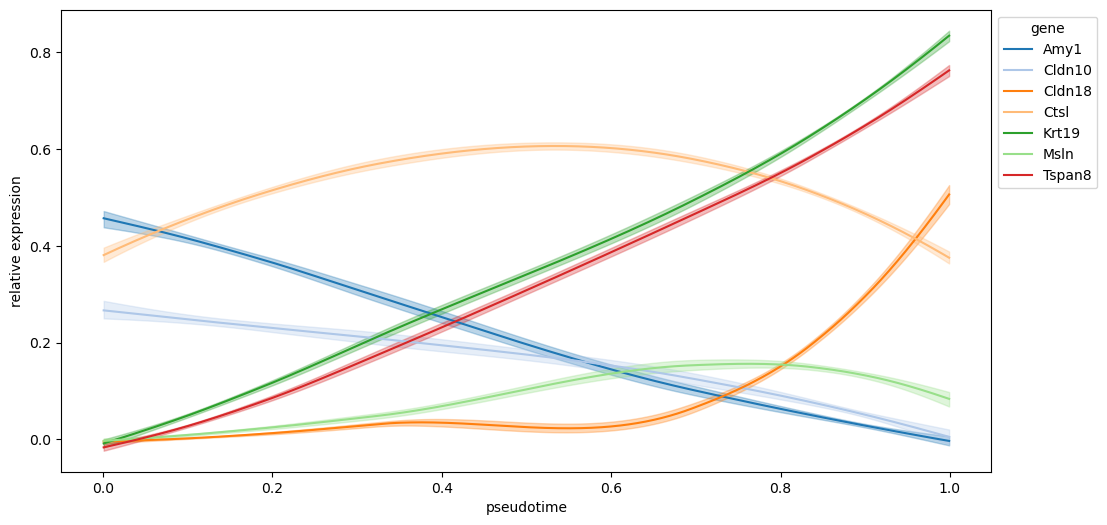

In [18]:
plt.figure (figsize=(12,6))

ax = sns.lineplot(data=df_final, x="pseudotime", y="relative expression", hue="gene", palette="tab20", legend="brief")
palette = sns.color_palette("tab20", len(genes_of_interest))
for i, gene in enumerate(genes_of_interest):
    ax.fill_between(df_all_genes["x"], df_all_genes[f"{gene}_conf_lower"], df_all_genes[f"{gene}_conf_upper"], color=palette[i], alpha=0.3)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium', title="gene")
plt.savefig("pseudotime_lineplot_loess.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.savefig("pseudotime_lineplot_loess.pdf", format='pdf', dpi=300, bbox_inches='tight')